<a href="https://colab.research.google.com/github/bforoura/AML/blob/master/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### The Titanic Dataset 

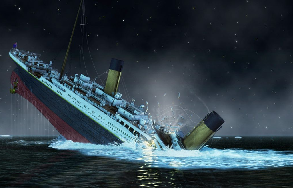

The set contains the survival status of 1309 passengers aboard the maiden voyage of the RMS Titanic in 1912 (the ships crew are not included), along with the passengers age, sex and class (which serves as a proxy for economic status), etc.

The purpose of this exercise is to train a number of classification models to learn the concept 'Survived' and compare their classification accuracy.

### Attributes:

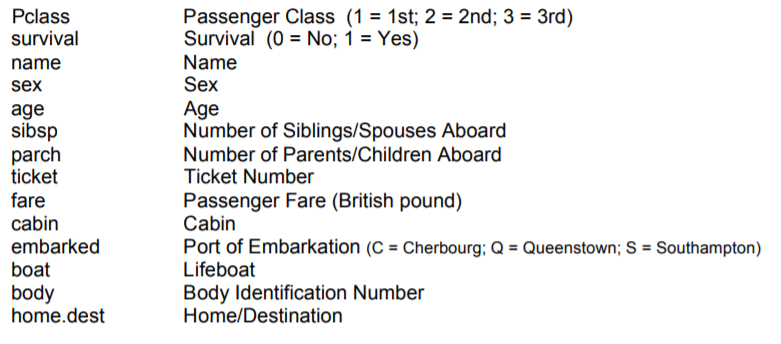



In [1]:
# read the dataset and remove unnecessary columns

import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

np.random.seed(42)

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

# drop non-essential columns
X.drop(['name', 'boat', 'body', 'home.dest', 'cabin', 'ticket'], axis=1, inplace=True)

# use the 80-20 rule for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)


In [2]:
# Let's examine the dataset features

X.head()

,pclass,sex,age,sibsp,parch,fare,embarked
0,1.0,female,29.0000,0.0,0.0,211.3375,S
1,1.0,male,0.9167,1.0,2.0,151.5500,S
2,1.0,female,2.0000,1.0,2.0,151.5500,S
3,1.0,male,30.0000,1.0,2.0,151.5500,S
4,1.0,female,25.0000,1.0,2.0,151.5500,S


### Correlation

Correlation or covariance is an important metric since the goal of feature engineering is to use an optimal set of  features to generate a prediction. We want to feed into the model highly correlated, relevant, and informative features. 

If certain features in the raw data are deemed useless, we need to either drop them or produce a new set of more correlated features.

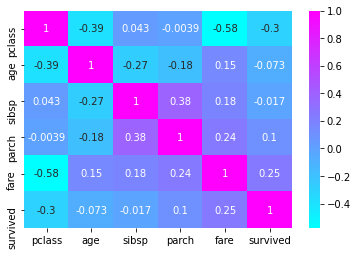

In [4]:
# produce a heatmap of feature correlations

import pandas as pd
import seaborn as sns

X_comb = pd.concat([X_train, y_train.astype(float)], axis=1)
g = sns.heatmap(X_comb[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'survived']].corr(),
                annot=True, 
                cmap = "cool")


# Note the weakly correlated features 'parch' and 'sibsp'


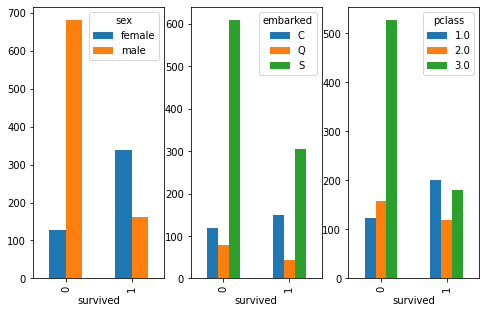

In [5]:
# let's cross tabulate and compute impact of pclass, gender, and embark on 
# the target variable

import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 3)

# impact of gender
ct1 = pd.crosstab(y[:], X['sex'])
ct1.plot.bar(ax = axes[0],figsize=(8,5))


# impact of embarked
ct2 = pd.crosstab(y[:], X['embarked'])
ct2.plot.bar(ax = axes[1], figsize=(8,5))


# impact of pclass
ct3 = pd.crosstab(y[:], X['pclass'])
ct3.plot.bar(ax = axes[2], figsize=(8,5))



In [6]:
# Check to see if there are any missing values

X.isnull().sum()

pclass        0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64

### Use imputation to handle missing values

From the analysis above, we find out that the columns that require imputation are as follows: age, fare, embarked

In [7]:
# 
X.dtypes

pclass       float64
sex         category
age          float64
sibsp        float64
parch        float64
fare         float64
embarked    category
dtype: object

### Pipelines are created to handle imputing, scaling, classification training, validation, etc.

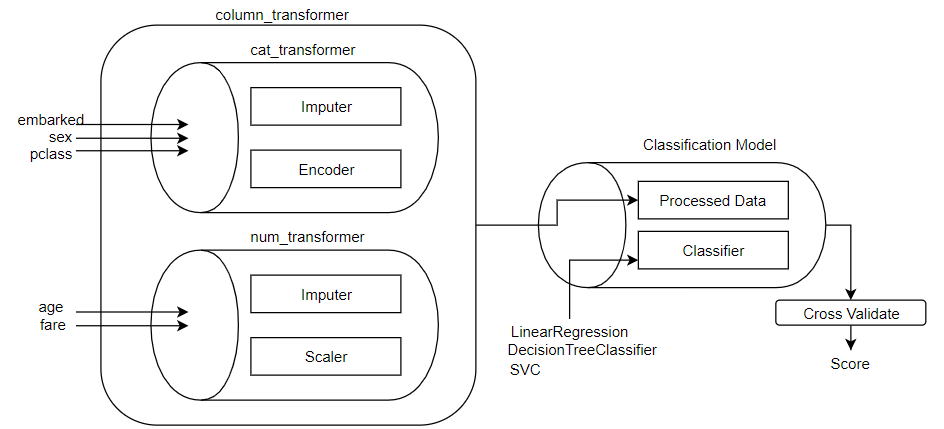


ColumnTransformer allows us to specify which pipeline will be applied to which column. 

By default imputers or transformers apply to the entire dataset, but we often prefer to have finer control over categorical and numerical columns. 

The combination of Pipeline and ColumnTransformer is powerful.

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler


########## First create a pipeline for the categoric attributes

cat_cols = ['embarked', 'sex', 'pclass']

cat_transformer = Pipeline(steps=[
    # strategies are mean, median, most_frequent, etc.
    ('imputer', SimpleImputer(strategy='most_frequent')),

    # In ordinal encoding, each unique category value is assigned an integer value.
    ('ordinal', OrdinalEncoder())
])




########## Second create a pipeline for the numeric attributes

num_cols = ['age', 'fare']

num_transformer = Pipeline(steps=[
    # Number of neighboring samples to use for K-nearest neighor imputation
    ('imputer', KNNImputer(n_neighbors=5)),

    # StandardScaler makes mean = 0 and scales the data to unit variance 
    ('scaler', StandardScaler())
])



########## Finally, apply column transformations

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])


### Classification Pipelines

Build several pipelinesfor various classifier models. 

Let’s verfiy each model performance using a 3-fold cross validation. 

Tabulate model accuracies for different classifiers.

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

num_folds = 10

########## A logistic regression model
lr_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

lr_score = cross_val_score(lr_clf, X, y, cv=num_folds, scoring="accuracy").mean()


########## A decicion tree with gini
gini_dt_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(criterion='gini'))])

gini_dt_score = cross_val_score(gini_dt_clf, X, y, cv=num_folds, scoring="accuracy").mean()


########## A decicion tree with entropy
entropy_dt_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(criterion='entropy'))])

entropy_dt_score = cross_val_score(entropy_dt_clf, X, y, cv=num_folds, scoring="accuracy").mean()


########## A random forest
rf_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

rf_clf_score = cross_val_score(rf_clf, X, y, cv=num_folds, scoring="accuracy").mean()


########## An RBF kernel classifier
rbf_svc_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(kernel='rbf'))])

rbf_svc_clf_score = cross_val_score(rbf_svc_clf, X, y, cv=num_folds, scoring="accuracy").mean()


########## A poly kernel classifier
poly_svc_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(kernel='poly'))])

poly_svc_clf_score = cross_val_score(poly_svc_clf, X, y, cv=num_folds, scoring="accuracy").mean()


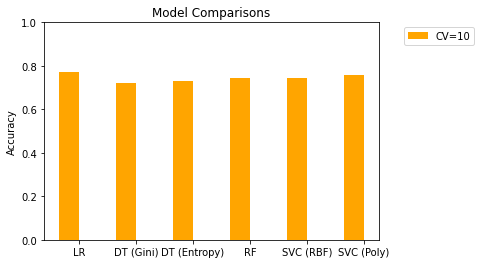

In [29]:
# Summarize the findings for all models

labels = ['LR', 'DT (Gini)', 'DT (Entropy)', 'RF', 'SVC (RBF)', 'SVC (Poly)']
training_scores = [lr_score, gini_dt_score, entropy_dt_score, rf_clf_score, rbf_svc_clf_score, poly_svc_clf_score]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_scores, width, label='CV=10', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_ylim(0,1)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor = (1.3, 1.0), loc='upper right')

plt.title('Model Comparisons')
plt.show()

### White or Transparent Models

Decision trees are able to describe what they have learned

|--- age <= 0.50
|   |--- fare <= 1.50
|   |   |--- sex <= -0.03
|   |   |   |--- truncated branch of depth 15
|   |   |--- sex >  -0.03
|   |   |   |--- truncated branch of depth 6
|   |--- fare >  1.50
|   |   |--- sex <= -0.19
|   |   |   |--- truncated branch of depth 19
|   |   |--- sex >  -0.19
|   |   |   |--- truncated branch of depth 5
|--- age >  0.50
|   |--- embarked <= -1.30
|   |   |--- fare <= 1.50
|   |   |   |--- class: 1
|   |   |--- fare >  1.50
|   |   |   |--- truncated branch of depth 8
|   |--- embarked >  -1.30
|   |   |--- fare <= 0.50
|   |   |   |--- truncated branch of depth 19
|   |   |--- fare >  0.50
|   |   |   |--- truncated branch of depth 18



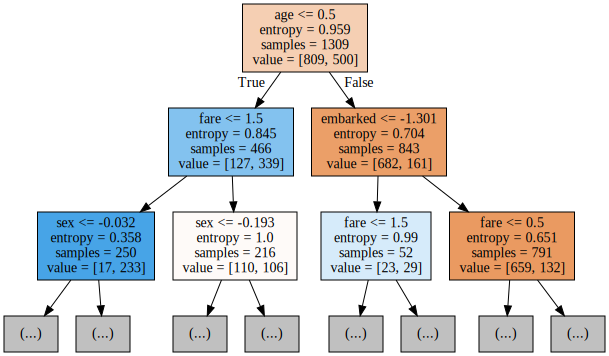

In [17]:
# Convert the decision tree model to text and graph

from matplotlib import pyplot
from sklearn.tree import export_text, export_graphviz
import graphviz

# we need to refit the DT model that is part of a composite pipe before exporting it as text
entropy_dt_clf['classifier'].fit(preprocessor.fit_transform(X), y)


# display the induced decision tree as a series of logical rules
text_representation = export_text(entropy_dt_clf['classifier'],
                                  feature_names=['embarked', 'sex', 'pclass', 'age', 'fare'],
                                  max_depth=2)
print(text_representation)


# draw the induced decision tree
dot_data = export_graphviz(entropy_dt_clf['classifier'],
                                  max_depth=2,
                                  feature_names=['embarked', 'sex', 'pclass', 'age', 'fare'],
                                  filled=True)

graph = graphviz.Source(dot_data, format="png") 
graph


Feature: 0, Score: 0.28194
Feature: 1, Score: 0.32437
Feature: 2, Score: 0.03779
Feature: 3, Score: 0.23555
Feature: 4, Score: 0.12033


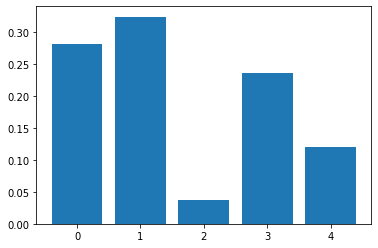

In [ ]:
# get feature importances from the model
importance = entropy_dt_clf['classifier'].feature_importances_

# summarize feature importances
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
 
# plot feature importances
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### Hyperparemeter Optimization

Find optimum values of hyperparameters using GridSearchCV:


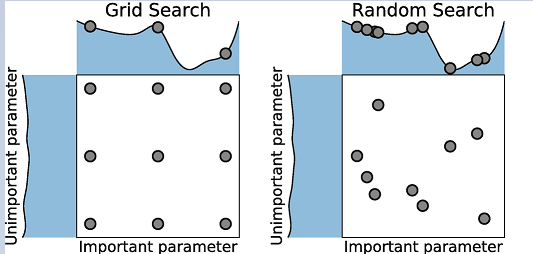


In [ ]:
# Use GridSearchCV to find optimum hyperparameter values for the DT model


# create a dictionary of all values we want to test
param_grid1 = { 'criterion':['gini','entropy'],    # impurity criterion
              'max_depth': np.arange(3, 15)}      # tree depth 
   
    
# use gridsearch to test all values
grid_search1 = GridSearchCV(entropy_dt_clf['classifier'], 
                           param_grid1, 
                           cv=3)
    
# fit the model 
grid_search1.fit(preprocessor.fit_transform(X_train), y_train)

   
print("The best achieved accuracy after hyperparameter optimization: %.2f \n" % (grid_search1.best_score_))

print("The best DT model hyperparameters:", grid_search1.best_params_)


The best achieved accuracy after hyperparameter optimization: 0.80 

The best DT model hyperparameters: {'criterion': 'entropy', 'max_depth': 3}


In [ ]:
# Use GridSearchCV to find optimum hyperparameter values for the SVC poly model


# create a dictionary of all values we want to test
param_grid2 = {'kernel':['poly'], 
              'gamma':['scale','auto'],      # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
              'degree': np.arange(4,8),      # polynomial degree
              'C': np.arange(1,10)}          # Regularization parameter
   
    
# use gridsearch to test all values
grid_search2 = GridSearchCV(poly_svc_clf['classifier'], 
                           param_grid2, 
                           cv=3)
    
# fit the model 
grid_search2.fit(preprocessor.fit_transform(X_train), y_train)

   
print("The best achieved accuracy after hyperparameter optimization: %.2f\n" % grid_search2.best_score_)

print("The best SVC poly model hyperparameters:", grid_search2.best_params_)


The best achieved accuracy after hyperparameter optimization: 0.79

The best SVC poly model hyperparameters: {'C': 9, 'degree': 4, 'gamma': 'auto', 'kernel': 'poly'}


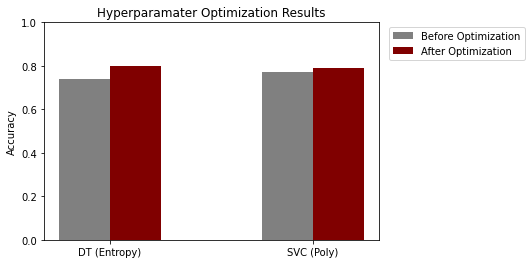

In [ ]:
# graph results of grid search for the two models

labels = ['DT (Entropy)', 'SVC (Poly)']
before_optimization_scores = [entropy_dt_score, poly_svc_clf_score]
after_optimization_scores = [grid_search1.best_score_, grid_search2.best_score_]

x = np.arange(len(labels))  # the label locations
width = 0.25                # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, before_optimization_scores, width, label='Before Optimization', color='gray')
rects2 = ax.bar(x + width/2, after_optimization_scores, width, label='After Optimization', color='maroon')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_ylim(0,1.0)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor = (1.45, 1.0), loc='upper right')

plt.title('Hyperparamater Optimization Results')
plt.show()

### Summary

In this exercise, the following functionalities were used on the Titanic dataset:

1.   pipelines to impute and prepare data
2.   pipelines to perform classification
1.   converting decision trees to text and graph
2.   performing grid search to optimize a few hyperparameters

The obtained results show that the average accuracy measure for all models was around 75% to 80%. GridSearchCV was not performed exhasutively although the last two experiments show that modest improvements can be made by just optimizing a few hyperparameters.



